In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List
import json
import pickle

import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import OneCycleLR

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint


print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data
from transformer import LGBMLeavesEncoder

PyTorch version: 2.4.1
PyTorch Lightning version: 2.4.0


In [2]:
# set seeds for reproducibility
np.random.seed(2112)
pl.seed_everything(2112)

Seed set to 2112


2112

In [3]:
# useful callbacks
class LearningRateMonitor(pl.Callback):
    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx % 100 == 0:  # Log every 100 batches
            lr = pl_module.optimizers().param_groups[0]['lr']
            pl_module.log('learning_rate', lr, prog_bar=True)   

class BestValRMSELogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_rmse = float('inf')

    def on_validation_epoch_end(self, trainer, pl_module):
        current_val_rmse = trainer.callback_metrics.get('val_rmse')
        if current_val_rmse is not None:
            self.best_val_rmse = min(self.best_val_rmse, current_val_rmse)
            pl_module.log('best_val_rmse', self.best_val_rmse, prog_bar=True)

***
### load and preprocess data

In [4]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [5]:
# Load the feature selection results
fs_type = 'uni95'

In [6]:
# Parameters
fs_type = "uni80"


In [7]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 215
Categorical features: 8
Text features: 0


In [8]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=True,
    scale_type="minmax",
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 215
Categorical Columns: 8


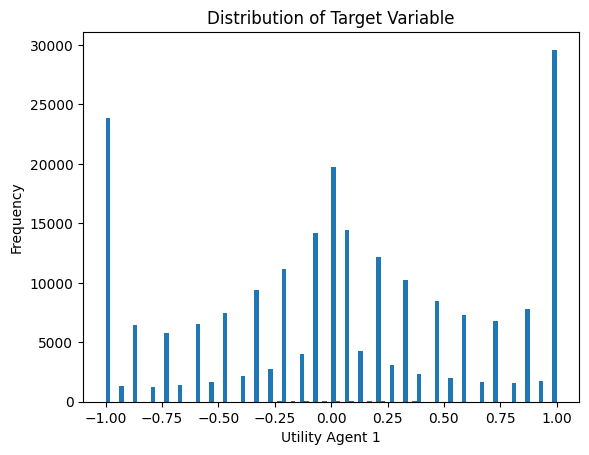

In [9]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [10]:
cat_input_dims = df_train[categorical_cols].nunique(axis=0).values.tolist()
print(cat_input_dims)

[3, 3, 72, 3, 4, 4, 72, 3]


In [11]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [12]:
class SoftOrdering1DCNN(pl.LightningModule):

    def __init__(self, 
            num_input_dim: int,
            cat_input_dims: list[int],
            output_dim: int,
            sign_size: int = 32,
            cha_input: int = 16, 
            cha_hidden: int = 32,
            K: int = 2,
            dropout_input: float = 0.2,
            dropout_hidden: float = 0.2, 
            dropout_output: float = 0.2,
            embedding_dropout: float = 0.2,
            learning_rate: float = 1e-3,
            weight_decay: float = 1e-5,
            embedding_dim: Optional[List[int]] = None,
            pct_start: float = 0.2,
            div_factor: float = 10.0,
            final_div_factor: float = 1e4):
        super().__init__()
        self.save_hyperparameters()

        # Initialize embedding dimensions if not provided
        if embedding_dim is None:
            embedding_dim = [min(50, int(1 + np.ceil(np.sqrt(dim)))) for dim in cat_input_dims]
        elif len(embedding_dim) != len(cat_input_dims):
            raise ValueError("Length of embedding_dim must match number of categorical features.")
        
        self.embedding_dim = embedding_dim
        self.embedding_dropout = embedding_dropout
        
        # Create embedding layers
        self.embeddings = nn.ModuleList(
            [nn.Embedding(dim, emb_dim) for dim, emb_dim in zip(cat_input_dims, embedding_dim)]
        )
        self.embedding_dropout_layer = nn.Dropout(self.embedding_dropout)

        # Calculate total input dimension after embeddings
        total_embedding_dim = sum(self.embedding_dim)
        total_input_dim = num_input_dim + total_embedding_dim

        # CNN architecture parameters
        hidden_size = sign_size * cha_input
        self.sign_size1 = sign_size
        self.sign_size2 = sign_size//2
        self.output_size = (sign_size//4) * cha_hidden
        self.cha_input = cha_input
        self.cha_hidden = cha_hidden
        self.K = K

        # Input projection
        self.batch_norm1 = nn.BatchNorm1d(total_input_dim)
        self.dropout1 = nn.Dropout(dropout_input)
        dense1 = nn.Linear(total_input_dim, hidden_size, bias=False)
        self.dense1 = nn.utils.weight_norm(dense1)

        # 1st conv layer
        self.batch_norm_c1 = nn.BatchNorm1d(cha_input)
        conv1 = nn.Conv1d(
            cha_input, 
            cha_input*K, 
            kernel_size=5, 
            stride=1, 
            padding=2,  
            groups=cha_input, 
            bias=False)
        self.conv1 = nn.utils.weight_norm(conv1, dim=None)
        self.ave_po_c1 = nn.AdaptiveAvgPool1d(output_size=self.sign_size2)

        # 2nd conv layer
        self.batch_norm_c2 = nn.BatchNorm1d(cha_input*K)
        self.dropout_c2 = nn.Dropout(dropout_hidden)
        conv2 = nn.Conv1d(
            cha_input*K, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv2 = nn.utils.weight_norm(conv2, dim=None)

        # 3rd conv layer
        self.batch_norm_c3 = nn.BatchNorm1d(cha_hidden)
        self.dropout_c3 = nn.Dropout(dropout_hidden)
        conv3 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=3, 
            stride=1, 
            padding=1, 
            bias=False)
        self.conv3 = nn.utils.weight_norm(conv3, dim=None)

        # 4th conv layer
        self.batch_norm_c4 = nn.BatchNorm1d(cha_hidden)
        conv4 = nn.Conv1d(
            cha_hidden, 
            cha_hidden, 
            kernel_size=5, 
            stride=1, 
            padding=2, 
            groups=cha_hidden, 
            bias=False)
        self.conv4 = nn.utils.weight_norm(conv4, dim=None)

        self.avg_po_c4 = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)
        self.flt = nn.Flatten()

        # Output head
        self.batch_norm2 = nn.BatchNorm1d(self.output_size)
        self.dropout2 = nn.Dropout(dropout_output)
        dense2 = nn.Linear(self.output_size, output_dim, bias=False)
        self.dense2 = nn.utils.weight_norm(dense2)

        # Training parameters
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.pct_start = pct_start
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor

        # Initialize lists to store validation outputs
        self.validation_targets = []
        self.validation_predictions = []

    def forward(self, x_num, x_cat):
        # Process categorical variables
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        embedded = torch.cat(embedded, dim=1)
        embedded = self.embedding_dropout_layer(embedded)
        
        # Concatenate numerical and embedded categorical features
        x = torch.cat([x_num, embedded], dim=1)

        # Input projection
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = nn.functional.celu(self.dense1(x))

        # Reshape for CNN
        x = x.reshape(x.shape[0], self.cha_input, self.sign_size1)

        # CNN backbone
        x = self.batch_norm_c1(x)
        x = nn.functional.leaky_relu(self.conv1(x))
        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x)
        x = self.dropout_c2(x)
        x = nn.functional.leaky_relu(self.conv2(x))
        x_s = x

        x = self.batch_norm_c3(x)
        x = self.dropout_c3(x)
        x = nn.functional.leaky_relu(self.conv3(x))

        x = self.batch_norm_c4(x)
        x = self.conv4(x)
        x = x + x_s
        x = nn.functional.leaky_relu(x)

        x = self.avg_po_c4(x)
        x = self.flt(x)

        # Output head
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        x = nn.functional.hardtanh(x)

        return x.squeeze(-1)

    def training_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_num, x_cat, y = batch
        y_hat = self(x_num, x_cat)
        loss = F.mse_loss(y_hat, y)
        self.log('valid_loss', loss, prog_bar=True)
        # Store targets and predictions for later use
        self.validation_targets.append(y)
        self.validation_predictions.append(y_hat)
        return loss
    
    def predict_step(self, batch, batch_idx):
        if len(batch) == 2:
            x_num, x_cat = batch
        elif len(batch) == 3:
            x_num, x_cat, _ = batch
        y_hat = self(x_num, x_cat)
        return y_hat

    def on_validation_epoch_end(self):
        # Concatenate all targets and predictions
        y = torch.cat(self.validation_targets)
        y_hat = torch.cat(self.validation_predictions)
        rmse = torch.sqrt(F.mse_loss(y_hat, y))
        self.log('val_rmse', rmse, prog_bar=True)
        # Clear the lists for next epoch
        self.validation_targets.clear()
        self.validation_predictions.clear()
                
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate, 
            weight_decay=self.weight_decay,
        )
        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=self.pct_start,
            div_factor=self.div_factor,
            final_div_factor=self.final_div_factor,
            anneal_strategy='cos',
            cycle_momentum=True,
            base_momentum=0.85,
            max_momentum=0.95,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
            },
        }

In [13]:
# List of oof scores: [0.4230125775077818, 0.4603824177612993, 0.4304655846763061, 0.4486351500995128, 0.4068174961896619]
# Average oof score: 0.4338626452469124

params = {
    # training params
    'batch_size': 512,
    'embedding_dropout': 0.2,
    'learning_rate': 5e-3,
    'weight_decay': 1e-5,
    'pct_start': 0.05,
    'div_factor': 100,
    'final_div_factor': 100,
    # model params
    'sign_size': 16,
    'cha_input': 64,
    'cha_hidden': 32,
    'K': 2,
    'dropout_input': 0.2,
    'dropout_hidden': 0.1,
    'dropout_output': 0.1,
}

In [14]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    """Train multiple 1DCNN models using cross-validation.
    
    Args:
        df_train: Training dataframe
        numerical_cols: List of numerical column names
        categorical_cols: List of categorical column names 
        target: Target column name
        split_list: List of train/val splits for cross-validation
    
    Returns:
        trained_models: List of trained 1DCNN models
        lgbm_encoders: List of fitted LGBM encoders
        oof: Out-of-fold predictions dataframe
        oof_scores: List of RMSE scores for each fold
    """
    trained_models = list()
    lgbm_encoders = list()
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train = df_train.iloc[train_index][numerical_cols + categorical_cols]
        y_train = df_train.iloc[train_index][target]
        X_valid = df_train.iloc[val_index][numerical_cols + categorical_cols]
        y_valid = df_train.iloc[val_index][target]

        lgbm_encoder = LGBMLeavesEncoder(
            num_cols=numerical_cols,
            cat_cols=categorical_cols,
            task='regression',
            n_estimators=100,
            num_leaves=63,
            random_state=2112,
            verbosity=-1,
        )
        lgbm_encoder.fit(X_train, y_train)
        X_train_leaves_lgbm = lgbm_encoder.transform(X_train, verbose=True)
        X_valid_leaves_lgbm = lgbm_encoder.transform(X_valid)
        
        X_train = pd.concat([X_train, X_train_leaves_lgbm], axis=1)
        X_valid = pd.concat([X_valid, X_valid_leaves_lgbm], axis=1) 

        _categorical_cols = (
            categorical_cols + lgbm_encoder.new_columns
        )
        _cat_input_dims = (
            df_train[categorical_cols].nunique(axis=0).values.tolist() + [63]*len(lgbm_encoder.new_columns)
        )

        lgbm_encoders.append(lgbm_encoder)

        train_dataset = TensorDataset(
            torch.tensor(X_train[numerical_cols].values, dtype=torch.float32),
            torch.tensor(X_train[_categorical_cols].values, dtype=torch.int32),
            torch.tensor(y_train.values, dtype=torch.float32)
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=params['batch_size'],
            shuffle=True,
            num_workers=8,
            persistent_workers=True
        )

        valid_dataset = TensorDataset(
            torch.tensor(X_valid[numerical_cols].values, dtype=torch.float32),
            torch.tensor(X_valid[_categorical_cols].values, dtype=torch.int32),
            torch.tensor(y_valid.values, dtype=torch.float32)
        )
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=params['batch_size'],
            shuffle=False,
            num_workers=8,
            persistent_workers=True
        )

        model = SoftOrdering1DCNN(
            num_input_dim=len(numerical_cols),
            cat_input_dims=_cat_input_dims,
            output_dim=1,
            # model params
            sign_size=params['sign_size'],
            cha_input=params['cha_input'],
            cha_hidden=params['cha_hidden'],
            K=params['K'],
            dropout_input=params['dropout_input'],
            dropout_hidden=params['dropout_hidden'],
            dropout_output=params['dropout_output'],
            embedding_dropout=params['embedding_dropout'],
            # training params
            learning_rate=params['learning_rate'], 
            weight_decay=params['weight_decay'],
            pct_start=params["pct_start"],
            div_factor=params["div_factor"],
            final_div_factor=params["final_div_factor"],
        )
        trainer = pl.Trainer(
            max_epochs=100,
            accelerator="mps", 
            callbacks=[
                EarlyStopping(
                    monitor='val_rmse',
                    patience=10,
                    mode='min',
                    verbose=False
                ), 
                LearningRateMonitor(), 
                BestValRMSELogger(),
                ModelCheckpoint(monitor='val_rmse', mode='min', save_top_k=1),
            ],
        )
        trainer.fit(
            model, 
            train_loader,
            valid_loader,
        )

        # Load the best model
        best_model_path = trainer.checkpoint_callback.best_model_path
        model = SoftOrdering1DCNN.load_from_checkpoint(best_model_path)
        trained_models.append(model)

        # Predict on validation set using trainer.predict with the prediction DataLoader
        predictions = trainer.predict(model, dataloaders=valid_loader)
        y_pred = torch.cat(predictions).squeeze().cpu().numpy()
         
        # Compute RMSE on scaled values
        y_valid = y_valid.values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, lgbm_encoders, oof, oof_scores


In [15]:
# call the function
trained_models1, lgbm_encoders1, oof1, oof_scores1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols,
    target='utility_agent1',
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_nn-1dcnn_{fs_type}_cv1.parquet', index=False)

Fold 1


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Predicting: |                                                                                                 …

Fold 1 - RMSE: 0.4281368291842271
Fold 2


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 2 - RMSE: 0.4571452422312684
Fold 3


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 3 - RMSE: 0.4242461362989795
Fold 4


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 4 - RMSE: 0.44660236673527604
Fold 5


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 5 - RMSE: 0.4058070598485942
List of oof scores: [0.4281368291842271, 0.4571452422312684, 0.4242461362989795, 0.44660236673527604, 0.4058070598485942]
Average oof score: 0.4323875268596691


In [16]:
# call the function
trained_models2, lgbm_encoders2, oof2, oof_scores2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    target='utility_agent1',
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_nn-1dcnn_{fs_type}_cv2.parquet', index=False)

Fold 1


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 1 - RMSE: 0.41966012780139667
Fold 2


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 2 - RMSE: 0.4065743687808691
Fold 3


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 3 - RMSE: 0.42827252131904764
Fold 4


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 4 - RMSE: 0.4290128306413378
Fold 5


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 5 - RMSE: 0.43618338744221596
List of oof scores: [0.41966012780139667, 0.4065743687808691, 0.42827252131904764, 0.4290128306413378, 0.43618338744221596]
Average oof score: 0.42394064719697344


In [17]:
# call the function
trained_models3, lgbm_encoders3, oof3, oof_scores3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    target='utility_agent1',
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_nn-1dcnn_{fs_type}_cv3.parquet', index=False)

Fold 1


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 1 - RMSE: 0.42801803261667865
Fold 2


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 2 - RMSE: 0.42177249047283144
Fold 3


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 3 - RMSE: 0.42012170688509387
Fold 4


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 4 - RMSE: 0.41199574104706843
Fold 5


Adding 100 new columns from LGBM leaves


/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


Loading `train_dataloader` to estimate number of stepping batches.



   | Name                    | Type              | Params | Mode 
-----------------------------------------------------------------------
0  | embeddings              | ModuleList        | 58.2 K | train
1  | embedding_dropout_layer | Dropout           | 0      | train
2  | batch_norm1             | BatchNorm1d       | 2.3 K  | train
3  | dropout1                | Dropout           | 0      | train
4  | dense1                  | Linear            | 1.2 M  | train
5  | batch_norm_c1           | BatchNorm1d       | 128    | train
6  | conv1                   | Conv1d            | 641    | train
7  | ave_po_c1               | AdaptiveAvgPool1d | 0      | train
8  | batch_norm_c2           | BatchNorm1d       | 256    | train
9  | dropout_c2              | Dropout           | 0      | train
10 | conv2                   | Conv1d            | 12.3 K | train
11 | batch_norm_c3           | BatchNorm1d       | 64     | train
12 | dropout_c3              | Dropout           | 0      | train
13 

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Fold 5 - RMSE: 0.41954553690754026
List of oof scores: [0.42801803261667865, 0.42177249047283144, 0.42012170688509387, 0.41199574104706843, 0.41954553690754026]
Average oof score: 0.42029070158584253


In [18]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
lgbm_encoders = [*lgbm_encoders1, *lgbm_encoders2, *lgbm_encoders3]

In [19]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4281
Score: 0.4571
Score: 0.4242
Score: 0.4466
Score: 0.4058
Average CV1 Score: 0.4324

CV2 OOF Scores:
Score: 0.4197
Score: 0.4066
Score: 0.4283
Score: 0.4290
Score: 0.4362
Average CV2 Score: 0.4239

CV3 OOF Scores:
Score: 0.4280
Score: 0.4218
Score: 0.4201
Score: 0.4120
Score: 0.4195
Average CV3 Score: 0.4203


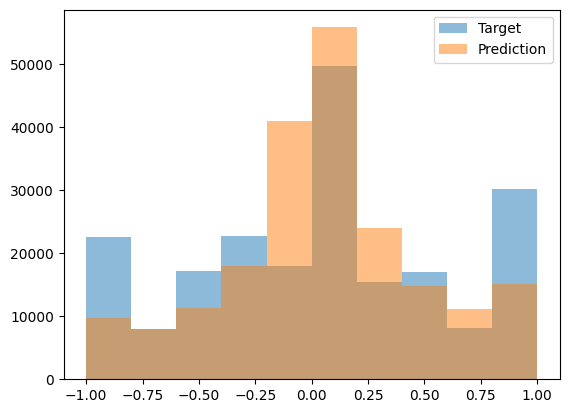

In [20]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [21]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [22]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )
        
    # Initialize an array to store predictions
    predictions = np.zeros(len(test_pd))
    
    # Make predictions using each trained model
    for lgbm_encoder,model in zip(lgbm_encoders, trained_models):

        # Select relevant features
        X_test_num = test_processed[numerical_cols].copy()
        X_test_cat = test_processed[categorical_cols].copy()

        # Add LGBM encoder leaves features
        lgbm_features = lgbm_encoder.transform(
            test_processed[numerical_cols+categorical_cols]
        )
        X_test_cat = pd.concat([X_test_cat, lgbm_features], axis=1)
        _categorical_cols = categorical_cols + lgbm_encoder.new_columns

        model.eval()
        with torch.no_grad():
            X_test_num_tensor = torch.tensor(
                X_test_num[numerical_cols].values, dtype=torch.float32
            )
            X_test_cat_tensor = torch.tensor(
                X_test_cat[_categorical_cols].values, dtype=torch.int32
            )
            batch_predictions = model(
                X_test_num_tensor, X_test_cat_tensor
            ).cpu().numpy().flatten()

        predictions += batch_predictions
    
    # Average the predictions
    predictions /= len(trained_models)
    
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [23]:
test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(test, sample_sub)

Id,utility_agent1
i64,f64
233234,0.136913
233235,-0.139139
233236,-0.040731


In [24]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [25]:
torch_save = {
    'models': [model.state_dict() for model in trained_models],
    'models_hparams': [model.hparams for model in trained_models],
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler,
    'lgbm_encoders': lgbm_encoders
}
torch.save(torch_save, f'./nn-1dcnn_predict_{fs_type}.pt')


***